In [2]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import pandas as pd
import numpy as np
import gzip
import json
import math
from datetime import datetime
from IPython.display import display
%matplotlib inline

from helper.rl_framework import *
from helper.orderbook_container import OrderbookContainer
from helper.manage_orderbooks_v2 import *
from helper.orderbook_trader import *


# Neural Network
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [3]:
# filename = '../data/snapshots/orderbooks_USDT_BTC_range1.15_samplesNone_snapshot2017-01-11T17:19.dict'
filename = '3000orderbooks'
currency_pair = 'USDT_BTC'
offset = 0
orderbooks = load_orderbook_snapshot(infile=filename, last_line=300)  #, first_line=offset+0, last_line=offset+10)
# display(timestamps)

print(orderbooks[0])
print(orderbooks[4])
print(orderbooks[9])

100%|██████████| 300/300 [00:23<00:00, 13.06it/s]

Loaded 300 orderbooks from file '3000orderbooks'.
OrderbookContainer from 2016-11-08T10:00
  499 bids (best: 705.0)
  407 asks (best: 705.45)
  kind: 'orderbook'
OrderbookContainer from 2016-11-08T10:04
  498 bids (best: 703.8)
  407 asks (best: 705.45)
  kind: 'orderbook'
OrderbookContainer from 2016-11-08T10:09
  499 bids (best: 704.11)
  408 asks (best: 705.0)
  kind: 'orderbook'


In [4]:
print(orderbooks[0])
print(orderbooks[200])
print(orderbooks[-1])

OrderbookContainer from 2016-11-08T10:00
  499 bids (best: 705.0)
  407 asks (best: 705.45)
  kind: 'orderbook'
OrderbookContainer from 2016-11-08T13:21
  517 bids (best: 705.51)
  411 asks (best: 707.4)
  kind: 'orderbook'
OrderbookContainer from 2016-11-08T15:00
  560 bids (best: 712.5)
  355 asks (best: 712.74)
  kind: 'orderbook'


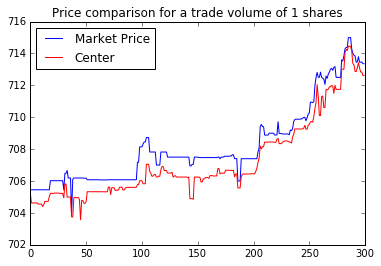

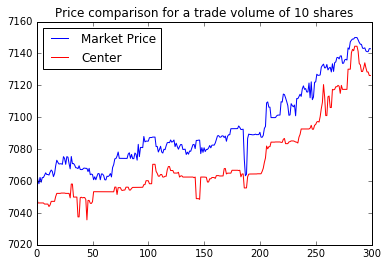

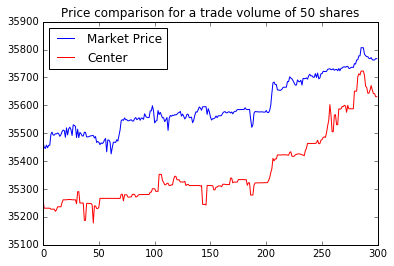

In [7]:
for volume in [1, 10, 50]:
    price = []
    center = []
    for i in range(len(orderbooks)):
        center.append(orderbooks[i].get_center() * volume)
        price.append(orderbooks[i].get_current_price(volume))
    plt.plot(price, color='blue', label='Market Price')
    plt.plot(center, color='red', label='Center')
    plt.title("Price comparison for a trade volume of {} shares".format(volume))
    plt.legend(loc='best')
    plt.show()

# for i in range(5):
#     orderbooks[i].plot(range_factor=1.005, figsize=(8,4))

In [9]:
V = 40  # trading volume
T = 10  # Time horizon: 10 periods -> P*T = 20 minutes
P = 2  # period length
episodes = 1

Episodes: 1, orderbooks per episode: 20


OrderbookContainer from 2016-11-08T10:00
  499 bids (best: 705.0)
  407 asks (best: 705.45)
  kind: 'orderbook'

,Amount,Type
702.680000,0.419626,bid
703.010000,3.637036,bid
703.230000,0.549537,bid
704.703971,NaN,center
706.180000,4.398300,ask
706.190000,0.508136,ask
706.450000,2.870490,ask


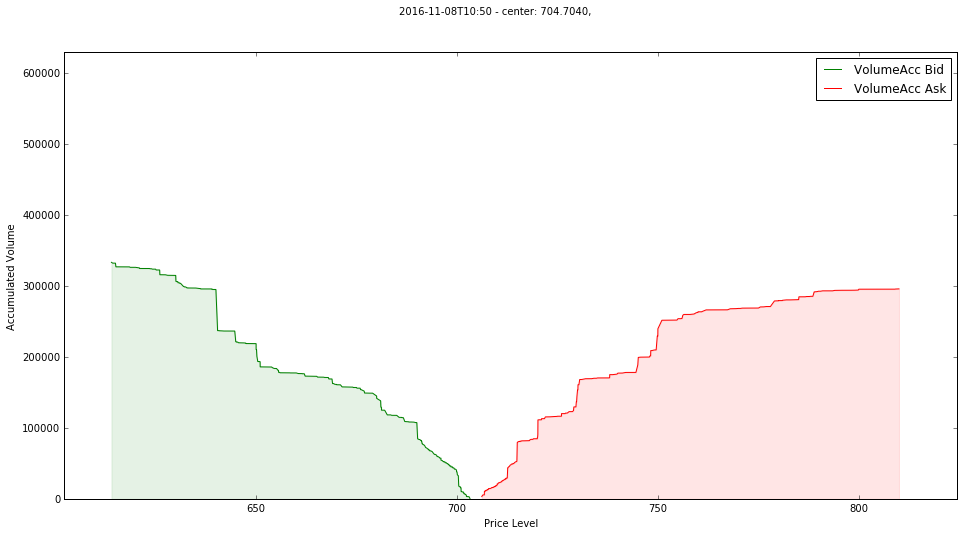

In [10]:
episode_windows = []
for e in range(0, episodes):
    window = [orderbooks[e*T*P + idx].copy() for idx in range(T*P)]
    episode_windows.append(window)
print("Episodes: {}, orderbooks per episode: {}".format(len(episode_windows), len(episode_windows[0])))
display(episode_windows[0][0])

ob = orderbooks[50]
display(ob.head(3))

ob.plot(range_factor=1.17)

Check computation time for trade_timespan for a timespan of 20 minutes.

* OrderbookTradingSimulator v1: 3000ms
* OrderbookTradingSimulator v2: 551ms

In [18]:
obs = episode_windows[0]
ots = OrderbookTradingSimulator()
%time ots.trade_timespan(obs[0:20], timespan=20, must_trade=False, volume=50, limit=707, verbose=False)

CPU times: user 552 ms, sys: 17.5 ms, total: 569 ms
Wall time: 568 ms


OrderbookContainer from 2016-11-08T10:19
  499 bids (best: 705.0)
  408 asks (best: 707.1)
  kind: 'orderbook'

In [ ]:
STATE_DIM = 2
actions = [-1, 0, 1, 3]
NUM_ACTIONS = len(actions)

In [ ]:
def base_model():
    model = Sequential()
    model.add(Dense(64, input_dim=STATE_DIM, activation='relu'))
    # model.add(Dense(32, activation='relu'))
    model.add(Dense(NUM_ACTIONS, activation='linear'))
    model.compile(loss='mse', optimizer='Adam')
    return model

model = base_model()

In [ ]:
max_steps = T
epochs = 10
gamma = 0.9

MAX_EXPLORATION_RATE = 1.
MIN_EXPLORATION_RATE = 0.05
DECAY_RATE = 0.01
epsilon = 1.

bufferSize = 5
batchSize = 3
replay = Memory(bufferSize)
# stores tuples of (S, A, R, S')

for i_episode in range(epochs):
    # i_episode = 0 ## test
    obs = episode_windows[0]

    ots = OrderbookTradingSimulator()
    
    volume = V
    time_left = T
    must_trade = False
    
    state = np.array([volume, time_left])
    # state = discretize_state(state)
    
    acc_cost = 0
    for step in range(max_steps):
        qval = model.predict(state.reshape(1, STATE_DIM))
        # print("     {}".format(qval))
            
        if random.random() < epsilon:
            # choose random action
            action = random.randint(0, len(actions)-1)
            # print("{}: random action {}".format(action, actions[action]))
        else:
            # choose best action from Q(s,a) values
            action = np.argmin(qval)
        print("{}: action {}".format(action, actions[action]))
        
        print(step*P, len(obs))
        ob = obs[step*P]
        # display(orderbook_preview(ob, 5))
        # display(orderbook_statistics(ob, currency_pair, timestamps[step*P]))
        
        ask = ob.get_ask()
        if not actions[action]:
            lim = None
        else:
            lim = ask + actions[action]
            
            
        if step == max_steps-1:
            must_trade = True

        new_ob = ots.trade_timespan(obs[step*P:(step+1)*P],
                                timespan=P, must_trade=must_trade,
                                volume=volume, limit=lim, verbose=False)
        
        volume = ots.history.volume_left.values[-1]
        time_left -= 1
        new_state = np.array([volume, time_left])
        cost = ots.history.cost.values[-1]
        
        acc_cost += cost
        
        replay.add((state, action, cost, new_state))
        if (replay.size() >= bufferSize):
            # wait for buffer to be filled, before getting started with training
            minibatch = replay.get_random_samples(batchSize)           
            
            X_train = []
            y_train = []
            for memory in minibatch:
                state_m, action_m, cost_m, new_state_m = memory
                
                qval_old = model.predict(state_m.reshape(1, STATE_DIM))               
                y = np.zeros((1, NUM_ACTIONS))
                y[:] = qval_old[:]
                
                qval_new_m = model.predict(new_state_m.reshape(1, STATE_DIM), batch_size=1)
                maxQ = np.max(qval_new_m)
                
                update = cost_m + (gamma*maxQ)
                y[0][action_m] = update  # target output

                X_train.append(state_m.reshape(STATE_DIM,))
                y_train.append(y.reshape(NUM_ACTIONS,))
            X_train = np.array(X_train)
            y_train = np.array(y_train)
                        
            # print("Game #: %s" % (i_episode,))
            model.fit(X_train, y_train, batch_size=batchSize, nb_epoch=1, verbose=0)
        state = new_state
        if volume == 0:
            break
       
    # reduce exploration rate
    if epsilon > MIN_EXPLORATION_RATE:
        epsilon = MAX_EXPLORATION_RATE *   math.exp(- DECAY_RATE * i_episode)
    info = "{:4d}/{}: epsilon={:5.3f}, acc_cost: {:0.5f}, last_cost {}, steps: {}"\
            .format(i_episode+1, epochs, epsilon,  acc_cost, cost, step)
    print(info)
    # if epsilon > 0:
    #     epsilon -= (1.5/epochs)
        

In [ ]:
for vol in [1, 10, 100]:
    for i, test in enumerate(obs):
        test = test.copy()
        val = test[test.Type == 'center'].Price.values[0]
        trader = OrderbookTradingSimulator()
        res = trader.check_market_value(test, volume=vol)

        plt.scatter(i, res, color='blue')
        plt.scatter(i, vol * -1. * get_ask(test), color='red', marker='*')
    plt.title("Market order price for {} shares".format(vol))
    plt.ylabel("cashflow")
    plt.xlabel("time")
    plt.xlim((-1,21))
    plt.show()

In [ ]:
vol = 1
for i, test in enumerate(obs):
    test = test.copy()
    val = test[test.Type == 'center'].Price.values[0]
    trader = OrderbookTradingSimulator()
    res = trader.check_market_value(test, volume=vol)

    plt.scatter(i, res)
plt.title("Market order price for {} shares".format(vol))
plt.ylabel("cashflow")
plt.xlabel("time")
plt.xlim((-1,21))
plt.show()

vol = 40
for i, test in enumerate(obs):
    test = test.copy()
    val = test[test.Type == 'center'].Price.values[0]
    trader = OrderbookTradingSimulator()
    res = trader.check_market_value(test, volume=vol)

    plt.scatter(i, res)
plt.title("Market order price for {} shares".format(vol))
plt.ylabel("cashflow")
plt.xlabel("time")
plt.xlim((-1,21))
plt.show()

vol = 1000
for i, test in enumerate(obs):
    test = test.copy()
    val = test[test.Type == 'center'].Price.values[0]
    trader = OrderbookTradingSimulator()
    res = trader.check_market_value(test, volume=vol)

    plt.scatter(i, res)
plt.title("Market order price for {} shares".format(vol))
plt.ylabel("cashflow")
plt.xlabel("time")
plt.xlim((-1,21))
plt.show()

vol = 10000
for i, test in enumerate(obs):
    test = test.copy()
    val = test[test.Type == 'center'].Price.values[0]
    trader = OrderbookTradingSimulator()
    res = trader.check_market_value(test, volume=vol)

    plt.scatter(i, res, col='blue')
    
plt.title("Market order price for {} shares".format(vol))
plt.ylabel("cashflow")
plt.xlabel("time")
plt.xlim((-1,21))
plt.show()

